Import packages:

In [1]:
#General
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#Imbalanced classes
from imblearn.under_sampling import RandomUnderSampler,TomekLinks, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

#Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

#Model Performance
from sklearn.metrics import classification_report, roc_auc_score, roc_curve,\
                            plot_precision_recall_curve,recall_score, precision_score,\
                            confusion_matrix, ConfusionMatrixDisplay

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

User Defined Functions:

In [2]:
def model_performance (test,pred):
    '''This functions gives model performance for binary classification models'''
    print(classification_report(test, pred))
    
def ConfusionMatrix (test, pred):

    cm = confusion_matrix(test, pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=list(rf.classes_))
    cmd.plot()

    group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

    print("\n Group Percentages:\n"
             "TN: 0,0 =", group_percentages[0],
             " ||FP: 0,1 =", group_percentages[1],
             " ||FN: 1,0 =", group_percentages[2],
             " ||TP: 1,1 =", group_percentages[3])

def plot_roc_auc(test,pred):
    
    fpr, tpr, _ = roc_curve(test, pred)
    auc = roc_auc_score(test, pred)

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
def plot_pr_auc(rf,test,pred):
    '''The perfect test will have a PRC that passes through the upper right corner
             i.e. corresponding to 100 % precision and 100 % recall
       closer a PRC is to the upper right corner, the better the test is.'''
    
    precision = precision_score(test, pred)
    recall = recall_score(test, pred)

    print('Precision: ',precision)
    print('Recall: ',recall)

Import Data:

In [3]:
data = pd.read_excel("C:\\Users\\91881\\Desktop\\CreditData\\default of credit card clients.xls", header = 1)

#view Column names:
#data.columns

#check for missing values in the columns: 
#data.isnull().sum()
#data.dropna() # to drop null values from dataset

In [32]:
pd.cut(data['AGE'], bins=10).value_counts()

(26.8, 32.6]      8261
(32.6, 38.4]      6514
(20.942, 26.8]    5127
(38.4, 44.2]      4812
(44.2, 50.0]      3017
(50.0, 55.8]      1425
(55.8, 61.6]       628
(61.6, 67.4]       171
(67.4, 73.2]        40
(73.2, 79.0]         5
Name: AGE, dtype: int64

Split Train and Test Sets:

In [4]:
#Split the dataframe into X & y , drop the ID column:
X = data.drop(columns= ['ID','default payment next month'], axis = 1 )
y = data['default payment next month']

#X.head()
#y.head()

In [5]:
#Split into Train (70%) and Test (30%) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_test.value_counts()

0    7009
1    1991
Name: default payment next month, dtype: int64

In [6]:
#feature selection:

from sklearn.feature_selection import mutual_info_classif, SelectKBest

#mutual_info_classif(X_train, y_train,discrete_features='auto', n_neighbors=3, copy=True, random_state=None)

fs = SelectKBest(mutual_info_classif, k=5)
f_reduced = fs.fit(X_train,y_train)


cols = fs.get_support(indices=True)
cols
selected_columns = X_train.iloc[:,cols].columns.tolist()
selected_columns

['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5']

In [7]:
#Random Forest

#fit on ORIGINAL data & predict
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)

print('Performance of Random Forest on Original Data')
model_performance (y_test,y_pred)

Performance of Random Forest on Original Data
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.68      0.38      0.49      1991

    accuracy                           0.82      9000
   macro avg       0.76      0.67      0.69      9000
weighted avg       0.81      0.82      0.80      9000



Sampling Techniques:

In [9]:
#Random Under Sampler:(X_rus, y_rus)
rus = RandomUnderSampler(random_state=42, replacement=True)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print('Original data:\n', y_train.value_counts())
print('Resample data:\n', y_rus.value_counts())

Original data:
 0    16355
1     4645
Name: default payment next month, dtype: int64
Resample data:
 0    4645
1    4645
Name: default payment next month, dtype: int64


In [10]:
#Random Over Sampler:(X_ros, y_ros)
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

print('Original data:\n', y_train.value_counts())
print('Resample data:\n', y_ros.value_counts())

Original data:
 0    16355
1     4645
Name: default payment next month, dtype: int64
Resample data:
 0    16355
1    16355
Name: default payment next month, dtype: int64


In [13]:
#Tomek links followed by SMOTE:

'''Step:1 Remove Majority class edge cases '''
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X_train, y_train)
        
#1 and 0 in the resampled data are not equal, we will be using an oversampling method
print('Original data:\n', y_train.value_counts())
print('Resample data:\n', y_tl.value_counts())

'''Step:2 Oversample the resampled data in step:1'''
smote = SMOTE()
X_tl_smote, y_tl_smote = smote.fit_resample(X_tl, y_tl)

#1 and 0 in this step should be equal in the resampled data
print('Resample data:\n', y_tl_smote.value_counts())

Original data:
 0    16355
1     4645
Name: default payment next month, dtype: int64
Resample data:
 0    15093
1     4645
Name: default payment next month, dtype: int64
Resample data:
 0    15093
1    15093
Name: default payment next month, dtype: int64


In [14]:
#ADASYN:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

print('Original data:\n', y_train.value_counts())
print('Resample data:\n', y_adasyn.value_counts())

Original data:
 0    16355
1     4645
Name: default payment next month, dtype: int64
Resample data:
 1    16737
0    16355
Name: default payment next month, dtype: int64


Modelling:

In [15]:
#fit on RANDOM UNDERSAMPLE data & predict
rf1 = RandomForestClassifier(n_estimators=400)
rf1.fit(X_rus, y_rus)
y_rus_pred=rf1.predict(X_test)
print('Performance of Random Forest on Random Undersample')
model_performance (y_test,y_rus_pred)

Performance of Random Forest on Random Undersample
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      7009
           1       0.42      0.67      0.52      1991

    accuracy                           0.72      9000
   macro avg       0.65      0.70      0.66      9000
weighted avg       0.78      0.72      0.74      9000




 Group Percentages:
TN: 0,0 = 57.09%  ||FP: 0,1 = 20.79%  ||FN: 1,0 = 7.22%  ||TP: 1,1 = 14.90%


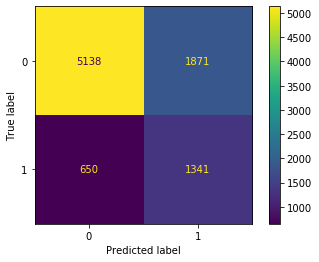

In [16]:
ConfusionMatrix (y_test,y_rus_pred)

In [18]:
#fit on OVERSAMPLE data & predict
rf2 = RandomForestClassifier(n_estimators=400)
rf2.fit(X_ros, y_ros)
y_ros_pred=rf2.predict(X_test)
print('Performance of Random Forest on Random Oversample')
model_performance (y_test,y_ros_pred)

Performance of Random Forest on Random Oversample
              precision    recall  f1-score   support

           0       0.85      0.92      0.89      7009
           1       0.63      0.45      0.52      1991

    accuracy                           0.82      9000
   macro avg       0.74      0.69      0.70      9000
weighted avg       0.80      0.82      0.81      9000



In [19]:
ConfusionMatrix (y_test,y_ros_pred)


 Group Percentages:
TN: 0,0 = 71.96%  ||FP: 0,1 = 5.92%  ||FN: 1,0 = 12.22%  ||TP: 1,1 = 9.90%


In [20]:
#fit on TOMEK LINK SMOTE data & predict
rf3 = RandomForestClassifier(n_estimators=400)
rf3.fit(X_tl_smote, y_tl_smote)
y_tl_smote_pred=rf3.predict(X_test)
print('Performance of Random Forest on TOMEK LINK SMOTE')
model_performance (y_test,y_tl_smote_pred)

Performance of Random Forest on TOMEK LINK SMOTE
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      7009
           1       0.52      0.52      0.52      1991

    accuracy                           0.79      9000
   macro avg       0.69      0.69      0.69      9000
weighted avg       0.79      0.79      0.79      9000




 Group Percentages:
TN: 0,0 = 67.19%  ||FP: 0,1 = 10.69%  ||FN: 1,0 = 10.68%  ||TP: 1,1 = 11.44%


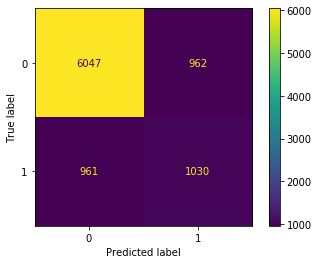

In [21]:
ConfusionMatrix (y_test,y_tl_smote_pred)

In [22]:
#fit on ADYSN data & predict
rf4 = RandomForestClassifier(n_estimators=400)
rf4.fit(X_adasyn, y_adasyn)
y_adasyn_pred=rf4.predict(X_test)
print('Performance of Random Forest on ADSYN')
model_performance (y_test,y_adasyn_pred)

Performance of Random Forest on ADSYN
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      7009
           1       0.52      0.50      0.51      1991

    accuracy                           0.79      9000
   macro avg       0.69      0.68      0.69      9000
weighted avg       0.78      0.79      0.78      9000




 Group Percentages:
TN: 0,0 = 67.44%  ||FP: 0,1 = 10.43%  ||FN: 1,0 = 11.02%  ||TP: 1,1 = 11.10%


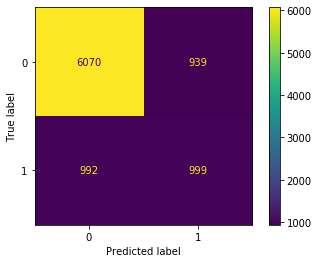

In [23]:
ConfusionMatrix (y_test,y_adasyn_pred)

No handles with labels found to put in legend.


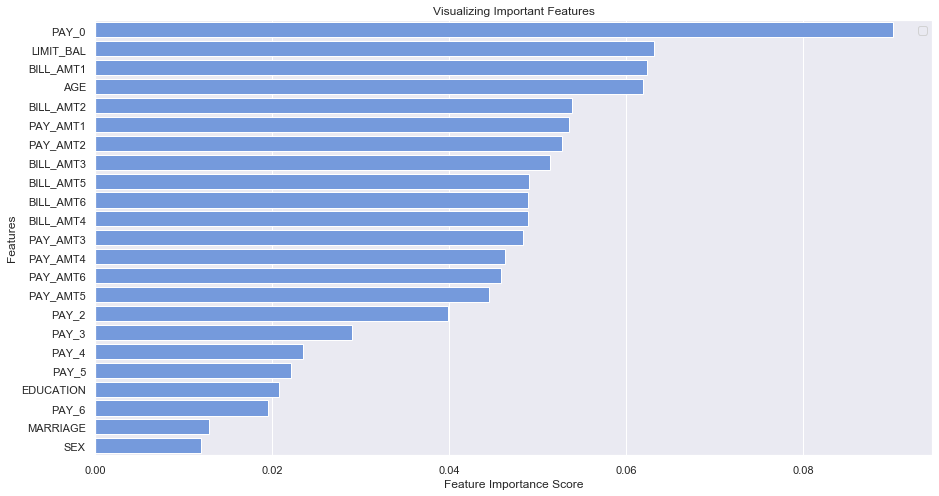

In [24]:
#feature importance for the best random forest model - rf2
feature_imp = pd.Series(rf2.feature_importances_,index=X.columns).sort_values(ascending=False)
#feature_imp

# Creating a bar plot

sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x = feature_imp, 
            y = feature_imp.index, 
            color = 'cornflowerblue')

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [25]:
# fit model no training data
xg = XGBClassifier()
xg.fit(X_train, y_train)

# make predictions for test data
y_pred = xg.predict(X_test)

print('Performance of XG Boost on Random Undersample')
model_performance (y_test,y_pred)

Performance of XG Boost on Random Undersample
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.66      0.37      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000



In [26]:
# fit model Random Under Sample  training data
xg1 = XGBClassifier()
xg1.fit(X_rus, y_rus)

# make predictions for test data
y_rus_pred = xg1.predict(X_test)

print('Performance of XG Boost on Random Undersample')
model_performance (y_test,y_rus_pred)

Performance of XG Boost on Random Undersample
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      7009
           1       0.39      0.67      0.49      1991

    accuracy                           0.69      9000
   macro avg       0.63      0.68      0.64      9000
weighted avg       0.77      0.69      0.72      9000



In [27]:
# fit model Random Over Sample training data
xg2 = XGBClassifier()
xg2.fit(X_ros, y_ros)

# make predictions for test data
y_ros_pred = xg2.predict(X_test)

print('Performance of XG Boost on Random OverSample')
model_performance (y_test,y_ros_pred)

Performance of XG Boost on Random OverSample
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      7009
           1       0.48      0.58      0.53      1991

    accuracy                           0.77      9000
   macro avg       0.68      0.70      0.69      9000
weighted avg       0.79      0.77      0.78      9000



In [28]:
#fit on TOMEK LINK SMOTE data & predict
xg3 = XGBClassifier()
xg3.fit(X_tl_smote, y_tl_smote)

# make predictions for test data
y_tl_smote_pred = xg3.predict(X_test)

print('Performance of XG Boost on Random OverSample')
model_performance (y_test,y_tl_smote_pred)

Performance of XG Boost on Random OverSample
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      7009
           1       0.48      0.50      0.49      1991

    accuracy                           0.77      9000
   macro avg       0.67      0.67      0.67      9000
weighted avg       0.77      0.77      0.77      9000



In [29]:
#fit on ADYSN data & predict
xg4 = XGBClassifier()
xg4.fit(X_adasyn, y_adasyn)
y_adasyn_pred=xg4.predict(X_test)
print('Performance of Random Forest on ADSYN')
model_performance (y_test,y_adasyn_pred)

Performance of Random Forest on ADSYN
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      7009
           1       0.47      0.47      0.47      1991

    accuracy                           0.77      9000
   macro avg       0.66      0.66      0.66      9000
weighted avg       0.77      0.77      0.77      9000



No handles with labels found to put in legend.


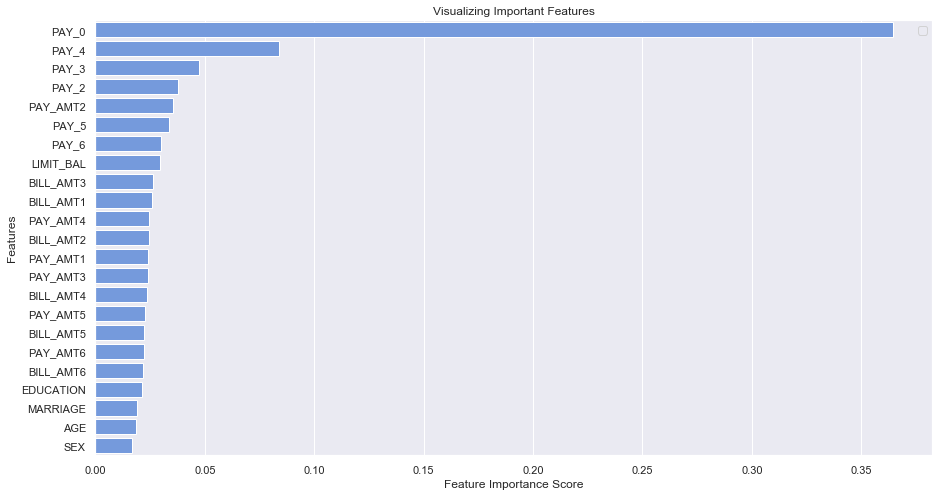

In [30]:
#feature importance for the best random forest model - rf2
feature_imp = pd.Series(xg2.feature_importances_,index=X.columns).sort_values(ascending=False)
#feature_imp

# Creating a bar plot

sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x = feature_imp, 
            y = feature_imp.index, 
            color = 'cornflowerblue')

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001481CC7D248>,
      dtype=object)

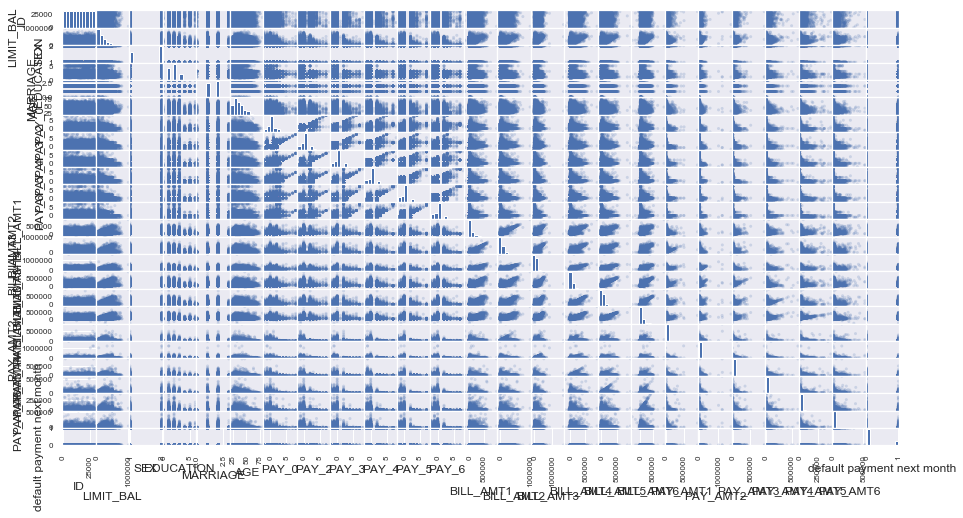

In [53]:
#sns.pairplot(data, hue="default payment next month")
pd.plotting.scatter_matrix(data, alpha=0.2)

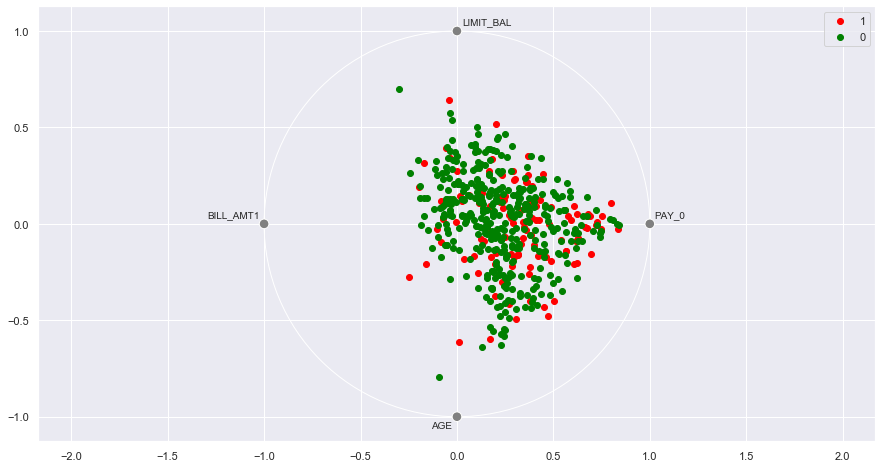

In [51]:
pd.plotting.radviz(frame = data.loc[0:500,['PAY_0','LIMIT_BAL','BILL_AMT1','default payment next month','AGE']],
                   class_column= 'default payment next month', 
                   color= ['red','green'])

In [48]:
data.loc[0:100,['PAY_0','LIMIT_BAL','BILL_AMT1','default payment next month']]

PAY_0  LIMIT_BAL  BILL_AMT1  default payment next month
0        2      20000       3913                           1
1       -1     120000       2682                           1
2        0      90000      29239                           0
3        0      50000      46990                           0
4       -1      50000       8617                           0
..     ...        ...        ...                         ...
96      -1     360000       3967                           0
97       0     150000      86009                           0
98       0      50000      18722                           0
99       0      20000      17973                           1
100     -2     140000        672                           0

[101 rows x 4 columns]